# QC Practical assignment

Daniel Francisco Teixeira Andrade - A100057

João Pacheco Mirra - A100083

----

## Exercise 2 - 2x2 binary sudoku

## Enunciado

----

Sudoku is a popular logic-based number-placement puzzle. The objective is to fill a grid with numbers so that each row, column, and designated subgrid contains all numbers without repetition.

For instance, in a 4x4 grid, there are 16 values to be assigned, with each position in the grid taking values 0 to 15. In a 2x2 sudoku, the problem is much simpler, and the rules are reduced to:

&nbsp; &nbsp; &nbsp; &nbsp; 1) No column may contain the same value twice

&nbsp; &nbsp; &nbsp; &nbsp; 2) No row may contain the same value twice

&nbsp; &nbsp; &nbsp; &nbsp; 3) Assignments are binary.

As you should convince yourself, there are only two possible binary assignments to solve the problem.

Tasks:

&nbsp; &nbsp; &nbsp; &nbsp; 1) Implement Grover's algorithm to find a solutions to the problem.

&nbsp; &nbsp; &nbsp; &nbsp; 2) Assess the algorithm's efficiency and complexity.

&nbsp; &nbsp; &nbsp; &nbsp; 3) Propose a generalization for a 3x3 sudoku and discuss potential limitations and resources required.

## Imports

----

In [1]:
import pennylane as qml
from collections import Counter
import math
from matplotlib import pyplot as plt

from typing import Any

## Implement Grover's algo to find a solution to the problem

----

#### Preparação do espaço de procura

O primeiro passo do `algoritmo de Grover` é a preparação do estado inicial.

Para tal, temos de colocar os qubits que representam o espaço de busca numa superposição uniforme.

No código,  isto é feito aplicando a porta `Hadamard` (`qml.Hadamard`) a cada qubit de `db`.

Além disso, preparamos um qubit auxiliar (`ancilla`) no estado |->, aplicando a porta Pauli-X (`qml.PauliX`) para inverter o seu estado de |0> para |1>, e em seguida a porta `Hadamard` para criar superposição. Este qubit ancilla é fundamental para que o `oracle` possa realizar a inversão de fase necessária para marcar os estados solução durante o algoritmo.

#### Fase iterativa: Oracle e Diffuser

Após a preparação do estado inicial, o algoritmo de Grover entra numa fase iterativa em que se aplicam repetidamente duas operações fundamentais: o `oracle` e o `diffuser`.

No código, para cada iteração:

- `Oracle` (inversão dos estados marcados):

    &nbsp; &nbsp; &nbsp; &nbsp; O `oracle` é reponsável por identificar os estados que satisfazem as condições do problema (os estados "solução") e multiplicar a amplitude por -1.
    
    &nbsp; &nbsp; &nbsp; &nbsp; Isto é feito através das operações `MultiControlledX` que atuam sobre o qubit ancilla apenas quando os qubits de `db=[0,1,2,3]` correspondem aos estados marcados, neste caso correspondem a `1001` e a `0110`. Assim, os estados que queremos destacar ficam com a sua fase invertida, enquanto os restantes permanecem inalterados. 

- `Diffuser` (amplificação dos estados marcados):

    &nbsp; &nbsp; &nbsp; &nbsp; Após o `oracle`, aplicamos o `diffuser`, que tem como objetivo aumentar as amplitudes dos estados marcados para que, na medição, eles sejam obtidos com maior probabilidade.
    
    &nbsp; &nbsp; &nbsp; &nbsp; Para isso, em cada qubit de `db = [0,1,2,3]` aplicamos uma porta `Hadamard` seguida de uma porta `Pauli-X` - esta combinação transforma o estado para que uma inversão condicional possa ser aplicada.
    
    &nbsp; &nbsp; &nbsp; &nbsp; A seguir, a operação `ControlledQubitUnitary` com uma porta `Pauli-Z` atua como uma inversão condicional no último qubit, controlado pelos restantes. Aplica a porta Z ao qubit 3 apenas se os qubits 0,1 e 2 estiverem no estado |1>.
    
    &nbsp; &nbsp; &nbsp; &nbsp; Finalemente, aplicam-se novamente as portas `Pauli-X` e `Hadamard` para reverter as transformações, completando o `diffuser`. 

#### Número ideal de iterações

O `oracle` e `diffuser` são repetidas um número ideal de vezes para maximizar a probabilidade de medir um estado solução no final do algoritmo. Esse número ideal de vezes é dada pela expressão:

$$
k = \left\lfloor \frac{\pi}{4 \cdot \arcsin\left(\sqrt{\frac{M}{2^n}}\right)} \right\rfloor
$$

onde:

- \( `M` \) = número de soluções (estados marcados pelo oráculo),
- \( `n` \) = número de qubits.

Podemos ainda simplicar a formula e retirar o `arcsin`, ficando apenas:

$$
k = \left\lfloor \frac{\pi}{4} \cdot \sqrt{\frac{M}{2^n}} \right\rfloor
$$

#### Representação do circuito

Para facilitar a visualizaçao do circuito e distinguir claramante cada fase do algoritmo, foram adicionadas barreiras (`qml.Barrier()`) em três pontos importantes:

- Entre a `inicilização dos qubits` e o `ínicio do loop iterativo`,

- Entre o `oracle` e o `diffuser` dentro do `loop`,

- E por fim, entre o `término da última iteração` e a `operação de medição` (retorno dos samples).

Essas barreiras atuam como divisores visuais no diagrama do circuito, ajudando a perceber melhor a estrutura e o fluxo do `algoritmo de Grover`.


(<Figure size 2300x600 with 1 Axes>, <Axes: >)

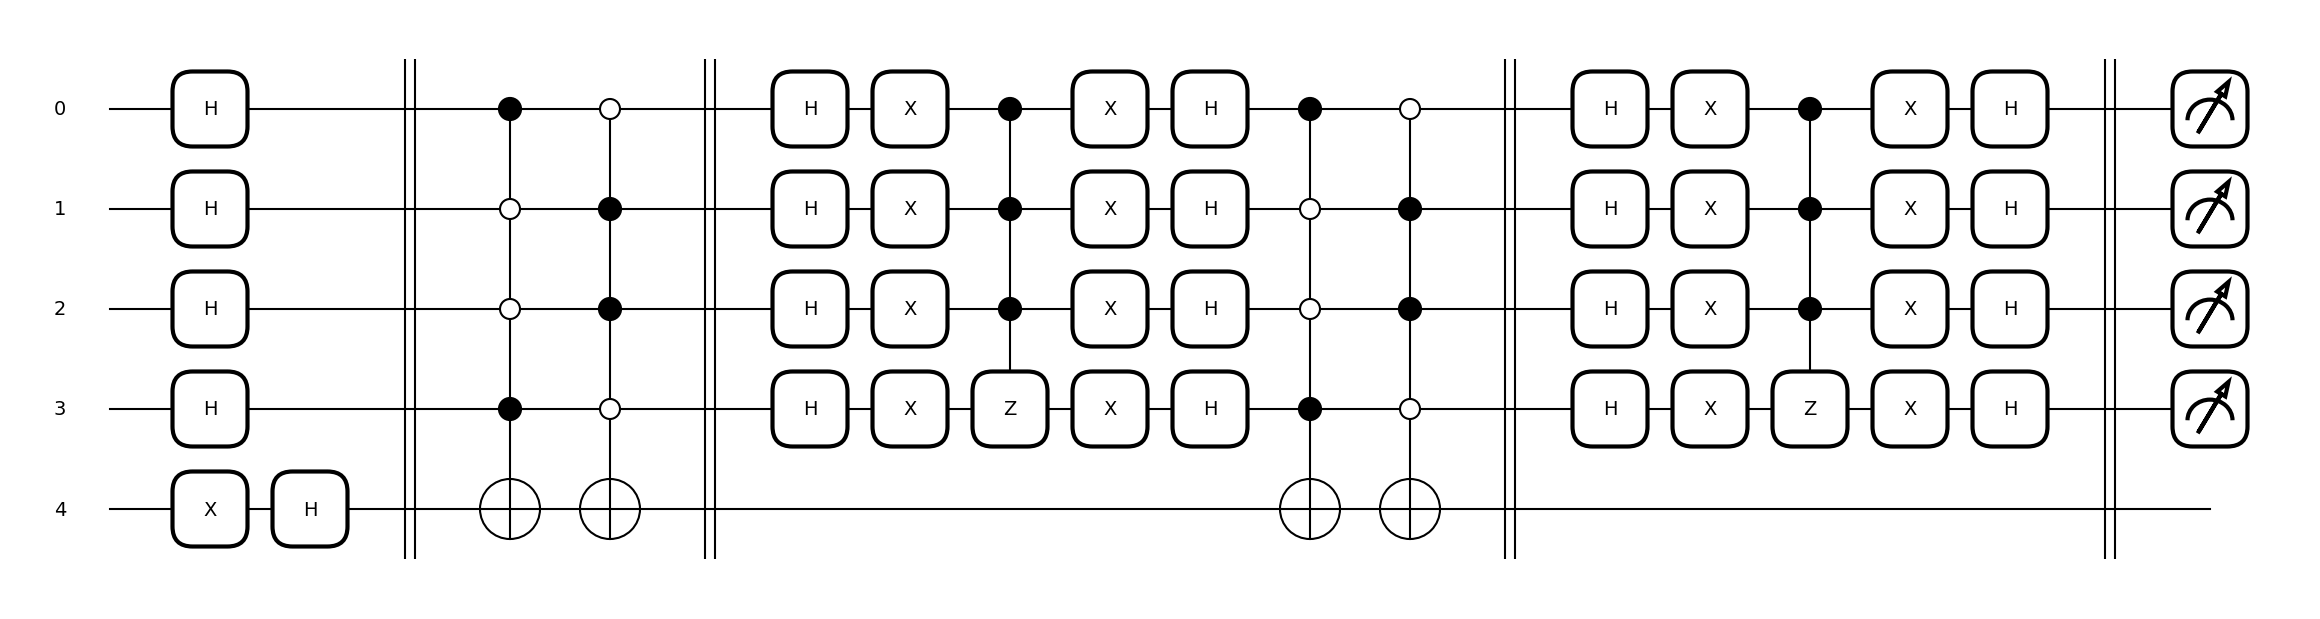

In [12]:
n_variable_qubits: int = 4
marked_states: int = 2

optimal_num_iterations: int = math.floor(
    math.pi / (4 * math.asin(math.sqrt(marked_states / 2**n_variable_qubits)))
)

dev: Any = qml.device("default.qubit", wires=5, shots=1024)
"""
Parameters:
    name (str): The name of the device to load. 
        'default.qubit' <pennylane.devices.default_qubit>`: a simple state 
        simulator of qubit-based quantum circuit architectures.
    
    wires (int): The number of wires (subsystems) to initialise the device with. 
    
    shots (int): Is an integer that defines how many times
            the circuit should be evaluated (or "sampled") to estimate 
            statistical quantities
"""

@qml.qnode(dev)
def run_grover_sudoku(iterations: int = 2) -> qml.measurements.SampleMP:

    #create registers 
    # 1001 => (0=1, 1=0, 2=0, 3=0)
    db: list[int] = [0,1,2,3] # 0000 to 1111 (all possibilities)
    ancilla: list[int] =[4]

    #superposition
    for i in db:
        qml.Hadamard(wires=i)
    
    qml.PauliX(wires=ancilla)
    qml.Hadamard(wires=ancilla)
    
    qml.Barrier() # for visual separation

    for it in range(iterations):

        # oracle (inverte os estados marcados)
        # solutions: 1001 and 0110
        qml.MultiControlledX(control_wires=db, wires=ancilla, control_values=[1, 0, 0, 1]) # marked: 1001
        qml.MultiControlledX(control_wires=db, wires=ancilla, control_values=[0, 1, 1, 0]) # marked: 0110
        
        qml.Barrier() # for visual separation

        #diffusion (amplifica os estados marcados)
        for i in db:
            qml.Hadamard(wires=i)
            qml.PauliX(wires=i)

        qml.ControlledQubitUnitary(qml.PauliZ(db[-1]), control_wires=db[:-1])

        for i in db:
            qml.PauliX(wires=i)
            qml.Hadamard(wires=i)
            
    qml.Barrier() # for visual separation
    
    # measurement
    return qml.sample(wires=db) # temos ruido

qml.draw_mpl(run_grover_sudoku)(optimal_num_iterations)

Total shots: 1024


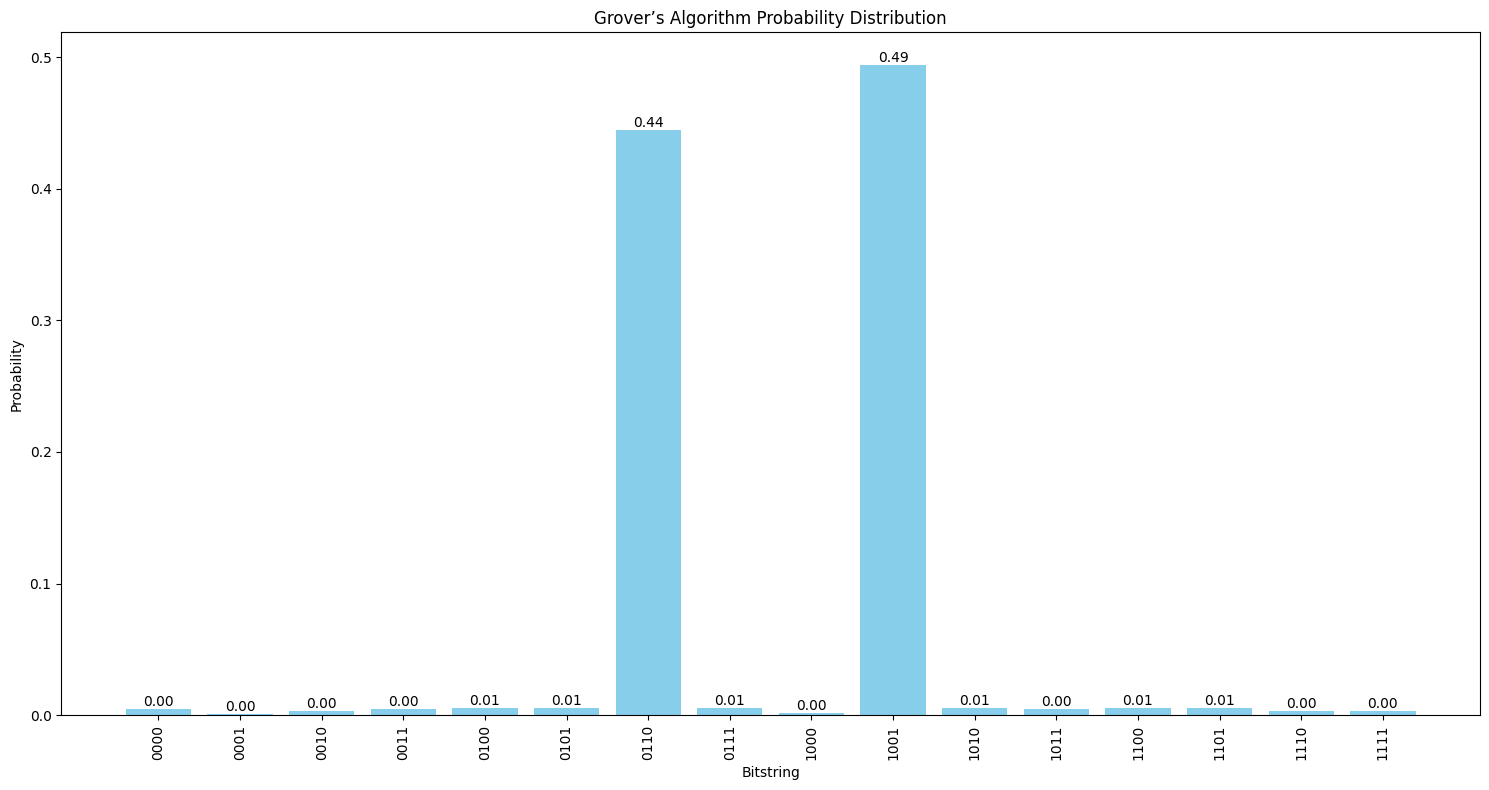

In [14]:
samples = run_grover_sudoku()

counts = Counter(''.join(map(str, s)) for s in samples)

total_shots = sum(counts.values())
print(f"Total shots: {total_shots}")


all_bitstrings = [format(i, '04b') for i in range(16)]
probabilities = {bit: counts.get(bit, 0) / total_shots for bit in all_bitstrings}
sorted_probs = [probabilities[bit] for bit in all_bitstrings]

plt.figure(figsize=(15, 8))
bars = plt.bar(all_bitstrings, sorted_probs, color='skyblue')
plt.xlabel('Bitstring')
plt.ylabel('Probability')
plt.title('Grover’s Algorithm Probability Distribution')

for bar, prob in zip(bars, sorted_probs):
    if prob > 0:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() ,
             f"{prob:.2f}", ha='center', va='bottom')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Assess the algo's efficiency and complexity

----

`Eficiência`:

$$
k = \left\lfloor \frac{\pi}{4 \cdot \arcsin\left(\sqrt{\frac{2}{16}}\right)} \right\rfloor = 2
$$

Com apenas 2 iterações, conseguimos aplificar significativamente a probabilidade de medir os estados soluções. Isto mostra uma melhoria clara em eficiência relativamente à abordagem clássica, que necessitaria até 16 tentativas.

`Complexidade`:

O algoritmo de `Grover` oferece uma `aceleração quadrática` em relação à busca clássica. Em vez de $\mathcal{O}(N)$, ele executa em:

$$
\mathcal{O}\left(\sqrt{\frac{M}{2^n}}\right)
$$


## Propose a generalization for 3x3 sudoku and discuss potential limitations and resources required

----

Um sudoku 3x3 consistem numa grelha de 3 linhas por 3 colunas (9 céluluas), onde cada célula deve conter um número entre 1 e 3, obedecendo às seguintes regras:

- Cada número aparece apenas uma vez por linha;

- Cada número aparece apenass uma vez por coluna;
 
`Limitações`:

- Baixa vantagem quântica: O número total de soluções válidas é pequeno `(12 soluções)`, o que limita a possibilidade de se explorar vantagem quântica significativa.

- Espaço de busca: Com $3^9 = 19.683$ possibilidades, o problema é relativamente pequeno. Embora seja possível aplicar o algoritmo de Grover para encontrar soluções de um sudoku 3x3, essa abordagem não é prática, já que qualquer pessoa consegue resolver esse quebra-cabeça de cabeça rapidamente.

`Recursos necessários`:

- Para representar os valores das células, cada célula precisa ser codificada em qubits - idealmente, 2 qubits por célula para representar os 3 possíveis valores (pois 2 qubits codificam até 4 estados). Ao todo temos cerca de 18 qubits para o tabuleiro completo.
 

## Extra

----

#### Implementação (via restrições)

(<Figure size 5800x1000 with 1 Axes>, <Axes: >)

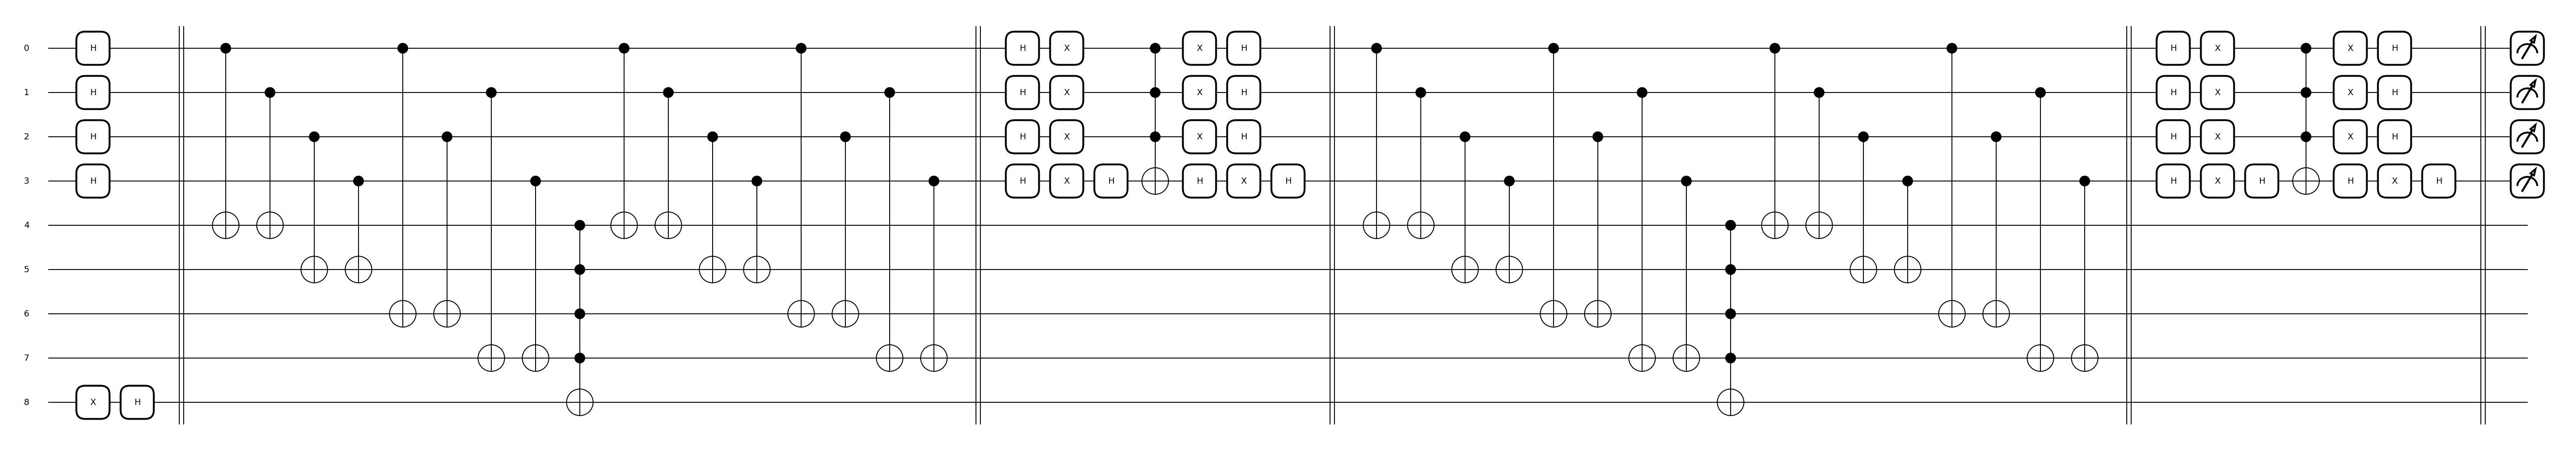

In [9]:
n_variable_qubits : int = 4
n_clause_qubits : int = 4
n_ancilla_qubit : int = 1
n_total_wires : int = n_variable_qubits + n_clause_qubits + n_ancilla_qubit


dev = qml.device("default.qubit", wires=n_total_wires, shots=1024)
"""
Parameters:
    name (str): The name of the device to load. 
        'default.qubit' <pennylane.devices.default_qubit>`: a simple state 
        simulator of qubit-based quantum circuit architectures.
    
    wires (int): The number of wires (subsystems) to initialise the device with. 
    
    shots (int): Is an integer that defines how many times
            the circuit should be evaluated (or "sampled") to estimate 
            statistical quantities
"""


variable_wires : list[int] = list(range(n_variable_qubits))
clause_eval_wires : list[int] = list(range(n_variable_qubits, n_variable_qubits + n_clause_qubits))
oracle_output_wire : int = n_variable_qubits + n_clause_qubits


sudoku_clauses: list[list[int]] = [
    [0,1],
    [2,3],
    [0,2],
    [1,3]
]

# número de soluções
marked_states : int = 2


optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(marked_states / 2**n_variable_qubits)))
)


# XOR using CNOTs: output = a XOR b
def XOR(a, b, output):
    qml.CNOT(wires=[a, output])
    qml.CNOT(wires=[b, output])


# Oracle: marks correct solutions
def sudoku_oracle():
    for i, clause in enumerate(sudoku_clauses):
        XOR(clause[0], clause[1], clause_eval_wires[i])

    # Flip output qubit if all clause qubits are 1
    qml.MultiControlledX(
        control_wires=clause_eval_wires,
        wires=oracle_output_wire,
        control_values='1'*len(clause_eval_wires)
    )

    # Uncompute
    for i, clause in enumerate(sudoku_clauses):
        XOR(clause[0], clause[1], clause_eval_wires[i])


# Grover diffuser: reflect around the average
def diffuser(wires):
    for w in wires:
        qml.Hadamard(wires=w)
    for w in wires:
        qml.PauliX(wires=w)

    qml.Hadamard(wires=wires[-1])
    qml.MultiControlledX(
        control_wires=wires[:-1],
        wires=wires[-1],
        control_values='1'*(len(wires)-1)
    )
    qml.Hadamard(wires=wires[-1])

    for w in wires:
        qml.PauliX(wires=w)
    for w in wires:
        qml.Hadamard(wires=w)


@qml.qnode(dev)
def run_grover_sudoku(num_iterations=2):
    
    #qml.Hadamard(wires=oracle_output_wire)
    #qml.PauliZ(wires=oracle_output_wire)
    # cima ou baixo são equivalentes (mas a de baixo é mais comum)
    qml.PauliX(wires=oracle_output_wire)
    qml.Hadamard(wires=oracle_output_wire)

    # Superposition over variable qubits
    for w in variable_wires:
        qml.Hadamard(wires=w)
    qml.Barrier() # for visual separation


    # Grover iterations
    for _ in range(optimal_num_iterations):  # 2 iterations for 4-variable space
        sudoku_oracle()
        qml.Barrier() # for visual separation
        diffuser(variable_wires)
        qml.Barrier() # for visual separation

    return qml.sample(wires=variable_wires)

qml.draw_mpl(run_grover_sudoku)(num_iterations=optimal_num_iterations)


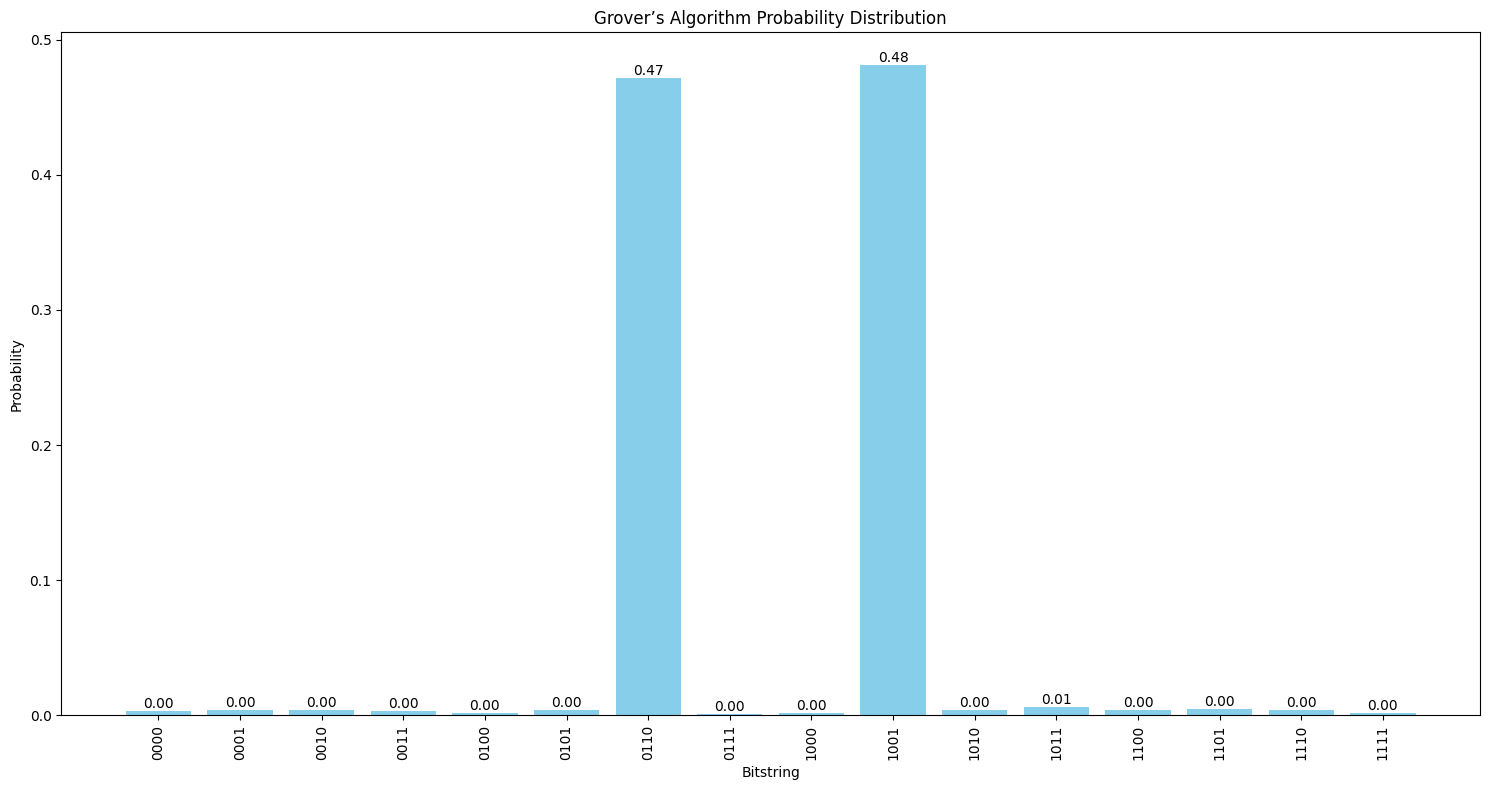

In [11]:
samples = run_grover_sudoku()

all_bitstrings = [format(i, '04b') for i in range(16)]
probabilities = {bit: counts.get(bit, 0) / total_shots for bit in all_bitstrings}
sorted_probs = [probabilities[bit] for bit in all_bitstrings]

plt.figure(figsize=(15, 8))
bars = plt.bar(all_bitstrings, sorted_probs, color='skyblue')
plt.xlabel('Bitstring')
plt.ylabel('Probability')
plt.title('Grover’s Algorithm Probability Distribution')

for bar, prob in zip(bars, sorted_probs):
    if prob > 0:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() ,
                     f"{prob:.2f}", ha='center', va='bottom')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Referências

----

[Wikipedia - Grover's Algorithm](https://en.wikipedia.org/wiki/Grover%27s_algorithm)

[IBM - Grover's Algorithm](https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/grovers-algorithm)

[IBM - Composer](https://quantum.ibm.com/composer/files/new)

[Quantum Computing StackEnchange ](https://quantumcomputing.stackexchange.com/questions/29007/solve-sudoku-using-grovers-algorithm)

[Qiskit - Grover's algorithm](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb)